In [31]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [ ]:
spark=SparkSession.builder\
    .appName("Flight Fare Prediction")\
    .master("local[*]")\
    .config("spark.sql.warehouse.dir", "/user/hive/warehouse")\
    .config("hive.metastore.uris", "thrift://localhost:9083")\
    .enableHiveSupport()\
    .getOrCreate()

25/08/08 18:59:40 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [ ]:
spark.sql("USE flight_db")
df=spark.sql("SELECT * FROM flight_fares").dropna()
df.show(5)

+-------+------+-----------+--------------+-----------+------------+----------------+-------+--------+---------+-----+
|airline|flight|source_city|departure_time|      stops|arrival_time|destination_city|  class|duration|days_left|price|
+-------+------+-----------+--------------+-----------+------------+----------------+-------+--------+---------+-----+
|Vistara|UK-852|     Mumbai|     Afternoon|two_or_more|     Evening|         Kolkata|Economy|    7.42|       29| 9506|
|Vistara|UK-852|     Mumbai|     Afternoon|two_or_more|       Night|         Kolkata|Economy|   10.58|       29| 9506|
|Vistara|UK-988|     Mumbai|         Night|        one|     Morning|         Kolkata|Economy|   11.67|       29|10288|
|Vistara|UK-988|     Mumbai|         Night|        one|     Evening|         Kolkata|Economy|   22.67|       29|10288|
| Indigo|6E-179|     Mumbai|       Morning|        one|     Evening|         Kolkata|Economy|    6.17|       29|10053|
+-------+------+-----------+--------------+-----

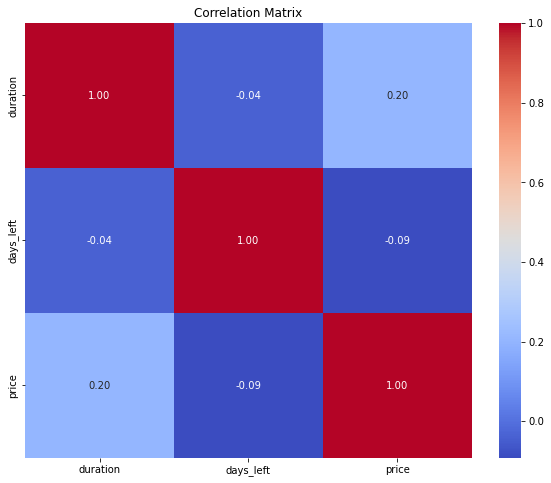

In [ ]:
pandas_df=df.toPandas()
plt.figure(figsize=(10, 8))
sns.heatmap(pandas_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
categorical_cols=['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
numerical_cols=['duration', 'days_left']
label_col='price'

In [ ]:
indexers=[StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid='keep') for col in categorical_cols]
encoders=[OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_vec") for col in categorical_cols]
assembler_inputs=[f"{col}_vec" for col in categorical_cols] + numerical_cols
assembler=VectorAssembler(inputCols=assembler_inputs, outputCol="features")

In [ ]:
train_df, test_df=df.randomSplit([0.8, 0.2], seed=42)

In [38]:
models = {
    "LinearRegression": LinearRegression(featuresCol="features", labelCol=label_col),
    "DecisionTree": DecisionTreeRegressor(featuresCol="features", labelCol=label_col),
    "RandomForest": RandomForestRegressor(featuresCol="features", labelCol=label_col),
    "GradientBoosted": GBTRegressor(featuresCol="features", labelCol=label_col)
}

In [ ]:
evaluate_rmse=RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
evaluate_mae=RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
evaluate_r2=RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")

In [ ]:
results=[]

In [ ]:
for name, model in models.items():
    stages=indexers + encoders + [assembler, model]
    pipeline=Pipeline(stages=stages)
    pipeline_trained_model=pipeline.fit(train_df)
    predictions=pipeline_trained_model.transform(test_df)

    rmse=evaluate_rmse.evaluate(predictions)
    mae=evaluate_mae.evaluate(predictions)
    r2=evaluate_r2.evaluate(predictions)
    results.append((name, rmse, mae, r2, pipeline_trained_model))

25/08/08 19:03:54 WARN Instrumentation: [88054f93] regParam is zero, which might cause numerical instability and overfitting.


25/08/08 19:03:56 WARN Instrumentation: [88054f93] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [48]:
results

[('LinearRegression',
  6800.344296649682,
  4573.220749101746,
  0.9101876999567675,
  PipelineModel_cdb9fdfcdbce),
 ('DecisionTree',
  5488.383095992629,
  3218.827447911719,
  0.9414990589664392,
  PipelineModel_9258c6b6b0c3),
 ('RandomForest',
  5536.375694922954,
  3329.963866073855,
  0.9404714748535402,
  PipelineModel_95f6cd1ecda1),
 ('GradientBoosted',
  4712.902327036935,
  2766.1620286972206,
  0.9568629050313419,
  PipelineModel_7c5fc9e9aa0a)]

In [ ]:
results_sorted=sorted(results, key=lambda x: x[1])
for name, rmse, mae, r2, pipeline_trained_model in results_sorted:
    print(f"{name} → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

GradientBoosted → RMSE: 4712.90, MAE: 2766.16, R²: 0.9569
DecisionTree → RMSE: 5488.38, MAE: 3218.83, R²: 0.9415
RandomForest → RMSE: 5536.38, MAE: 3329.96, R²: 0.9405
LinearRegression → RMSE: 6800.34, MAE: 4573.22, R²: 0.9102


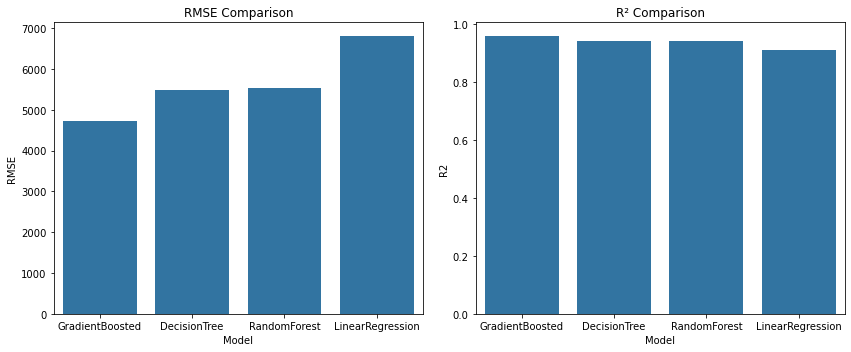

In [ ]:
results_df=pd.DataFrame(results_sorted, columns=["Model", "RMSE", "MAE", "R2", "PipelineModel"])
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x="Model", y="RMSE", data=results_df)
plt.title("RMSE Comparison")
plt.subplot(1, 2, 2)
sns.barplot(x="Model", y="R2", data=results_df)
plt.title("R² Comparison")
plt.tight_layout()
plt.show()

In [ ]:
best_model_name, best_rmse, best_mae, best_r2, best_model_pipeline = results_sorted[0]
model_path=f"./best_model_{best_model_name}"
best_model_pipeline.write().overwrite().save(model_path)